In [59]:
using JLD
using PyPlot
using Statistics, StatsBase #mean and std

In [60]:
nombrecm="/home/karel/BRWFiles/Facilitada/Completo_19115s1cut_single_event_prepro-CM.jld"
archivo=load(nombrecm)
DatosCMP=archivo["CMP"]
DatosCMN=archivo["CMN"];
evocada=false
nmax=length(DatosCMP) #cuantos cuadros hay

2000

In [61]:
DatosCMP[1337]

5×3 Array{Float64,2}:
 41.5876   64.0     103.379 
 35.976    63.202    46.8594
 23.4238   52.2318   54.8587
  9.44031  11.0367   71.579 
 31.2133   61.6862   61.8519

In [62]:
DatosCMP[1341]

2×3 Array{Float64,2}:
 41.8477   4.64812  62.4733
 21.4426  47.5024   46.803 

In [63]:
function leeunmegaarrayarchivos(NomineGeneralis::AbstractString, desde=35, hasta=501)
    LeMegaArray=Array[]
    for t=desde:hasta
      #  println("$NomineGeneralis-$t.dat")
        CMx=try 
            readdlm("$NomineGeneralis-$t.dat")
        catch
            []
        end
        push!(LeMegaArray, CMx)
    end
    return LeMegaArray
    end


function leunjlddeCM(datos, desde=1, hasta=300)
    LeMegaArray=Array[]
    for t=desde:hasta
      #  println("$NomineGeneralis-$t.dat")
        CMx=try 
        readdlm("$NomineGeneralis-$t.dat")
        catch
            []
        end
        push!(LeMegaArray, CMx)
    end
    return LeMegaArray
end



leunjlddeCM (generic function with 3 methods)

Para Evocados, hay un par de variables temporales para considerar:
- retrazo: el tiempo en cuadros que hubo desde el comienzo del registro hasta el estimulo
- latencia: el tiempo en cuadros que hubo desde el estimulo hasta que paso algo interesante


In [64]:
freq=7.022 # la frecuencia de muestreo en kHz de los experimentos viejos

if evocada
    retms=5.0 #retrazo en milisec
    latms=4.0 #latencia en milisec
    retrazo=round(Int, retms * freq)
    lat=round(Int, latms * freq)
    desde=retrazo+lat
    hasta=300
else
    retms=0
    latms=0
    retrazo=0
    lat=0
    desde=1
    hasta=nmax
end

2000

In [65]:
function dist2D(x,y)
    result=sqrt((x[1]-y[1])^2+(x[2]-y[2])^2)
    return result
end

function difgordis(x,y)
    result=abs(x-y)/max(abs(x),abs(y))
    return result
end

difgordis (generic function with 1 method)

In [66]:
difgordis(0.21,0.29)

0.27586206896551724

In [67]:
function encuentraTrayectorias(Datos, mincadena=20, mingordo=2.0, desde=1,hasta=20)

toleradist=16.0*sqrt(2)
#toldifgordis=0.33
tau=1
t=1
j=1

Catenario=Dict{Integer, Array{Any}}()
Cadena=[0 0 0 0]
tnum=1
CopiaMegaArray=deepcopy(Datos);
NumFrames=length(Datos)
FakeNumFrames=NumFrames



while t <= FakeNumFrames-1 
    
    tau=t
    
    @label arrrrh
 
        if(CopiaMegaArray[tau]==[])
            
            jmax,nada=0,0
        else
          
     jmax,nada= size(CopiaMegaArray[tau])
        end
    
        
    while j <=jmax && tau<FakeNumFrames
            
            if abs(CopiaMegaArray[tau][j,3]) > mingordo
                
            Eslabon=[transpose(CopiaMegaArray[tau][j,:]) tau]
            Cadena=vcat(Cadena, Eslabon)
         #   println("Papa t: ", t, "  tau: ", tau, " y  j: ",j )
            mindist=2
            kasterisco=1
                
                if CopiaMegaArray[tau+1]==[]
                    kmax,nada=0,0
                else
                kmax, nada= size(CopiaMegaArray[tau+1])
                end
                huboalgo=false
          
        #    kmax=5
            
            for k=1:kmax
                
                EslabonTentativo=CopiaMegaArray[tau+1][k,:]
            #    println(EslabonTentativo)
                    if abs(EslabonTentativo[3])>mingordo
                    dist=dist2D(Eslabon,EslabonTentativo)                  
                    if dist<mindist
                        mindist=dist
                        kasterisco=k
                        
                       # println(kasterisco, "=k*", k, "=k")
                        huboalgo=true
                    end
                end
            
            end    
            
            if huboalgo && mindist<toleradist
                #quitamos el anterior
                CopiaMegaArray[tau][j,3]=0.0000 
               # println(mindist," ", t, " ", tau+1 ," ", kasterisco )
                
                if tau+1<FakeNumFrames
                    tau+=1
                    j=kasterisco
      #              println("Pepe t: ", t, "  tau: ", tau, " y  j: ",j )
                    @goto arrrrh
                
                else
                    
                    Eslabon=[transpose(CopiaMegaArray[tau+1][kasterisco,:]) tau+1]
                    Cadena=vcat(Cadena, Eslabon)
      #              println("Pipi t: ", t, "  t: ", t, " y  j: ",j )
                    j+=1
                    tau=t
                    
                    if size(Cadena)[1]>mincadena
                        #push!(Catenario, Cadena[2:end,:])
                        Catenario[tnum]=Cadena[2:end,:]
                        tnum+=1
                    end
                    
                    Cadena=[0 0 0 0]
                    @goto arrrrh
                end
                                
            else
                
                if size(Cadena)[1]>mincadena
                    # veamos si funciona  mejor como dict 
                        #push!(Catenario, Cadena[2:end,:])
                        Catenario[tnum]=Cadena[2:end,:]
                        tnum+=1
                end
                Cadena=[0 0 0 0]
                j+=1
                tau=t
                @goto arrrrh
            end
                       
        end #cierra sobre el if de  la masa 
                
        j+=1                    
        tau=t
    
    end
    @label urrr
      
    j=1
    t+=1
    tau=t
    Cadena=[0 0 0 0]
        end 
    
    return Catenario
end

encuentraTrayectorias (generic function with 5 methods)

In [68]:
(desde, hasta)


(1, 2000)

In [69]:
pesomin=
longmin=3

3

In [70]:
#Recuerda el segundo argumento es la longitud mínima de la cadena
@time CatenarioPositivo=encuentraTrayectorias(DatosCMP,longmin,pesomin,desde,hasta);


  0.356622 seconds (1.47 M allocations: 58.009 MiB, 6.35% gc time)


In [71]:
CatenarioNegativo=encuentraTrayectorias(DatosCMN,longmin,pesomin,desde,hasta);

In [72]:
nombreout=nombrecm[1:end-6]*"Tray-todas.jld"
nota="longitud minima fue $longmin, peso minimo fue $pesomin "
save(nombreout, "CatenarioNegativo", CatenarioNegativo, "CatenarioPositivo", CatenarioPositivo, "nota", nota)

In [73]:
length(CatenarioPositivo), length(CatenarioNegativo)

(1069, 1261)

In [74]:
CatenarioPositivo

Dict{Integer,Array{Any,N} where N} with 1069 entries:
  306 => Any[25.2382 53.0507 177.147 670.0; 25.0217 52.9473 182.973 671.0; … ; …
  29  => Any[20.5786 56.4202 53.8821 430.0; 20.5396 56.4637 58.6712 431.0; … ; …
  74  => Any[41.5016 24.1021 96.6683 547.0; 41.7366 24.5277 73.6749 548.0; 41.6…
  905 => Any[30.1594 46.3593 77.8674 1194.0; 30.4318 46.5006 74.5799 1195.0; … …
  176 => Any[57.5568 53.1607 85.3567 595.0; 58.2445 53.042 53.966 596.0; 58.227…
  892 => Any[22.1982 47.2348 49.6134 1183.0; 22.0603 47.4356 68.195 1184.0; … ;…
  285 => Any[56.7756 21.5744 509.51 654.0; 56.5947 21.1398 498.925 655.0; 56.13…
  318 => Any[61.4014 53.8376 66.9916 676.0; 60.7183 54.6064 129.662 677.0; … ; …
  873 => Any[42.3506 13.638 73.9378 1169.0; 42.2542 13.3934 76.4581 1170.0; … ;…
  975 => Any[35.3472 10.1818 63.231 1254.0; 35.1424 10.4246 69.3462 1255.0; … ;…
  354 => Any[55.2216 51.0031 127.08 704.0; 55.0266 51.0314 154.558 705.0; … ; 5…
  610 => Any[27.6687 53.836 989.861 927.0; 26.9915 52.0

In [75]:
nombreout

"/home/karel/BRWFiles/Facilitada/Completo_19115s1cut_single_event_prepro-Tray-todas.jld"

In [76]:
values(CatenarioNegativo)

Base.ValueIterator for a Dict{Integer,Array{Any,N} where N} with 1261 entries. Values:
  Any[58.9985 54.2545 -65.2574 650.0; 58.904 54.2466 -60.1744 651.0; 58.2035 54…
  Any[44.9808 59.5862 -64.7245 1279.0; 46.0808 59.2317 -128.931 1280.0; 46.1673…
  Any[59.6534 30.8492 -75.6957 248.0; 59.4184 31.2269 -83.7655 249.0; … ; 58.81…
  Any[22.0511 8.72235 -47.8344 1332.0; 21.8417 8.67262 -67.1969 1333.0; 21.4832…
  Any[50.5688 6.49573 -54.1497 543.0; 50.5652 6.47066 -57.0823 544.0; 50.5272 6…
  Any[60.3198 47.2568 -64.169 1114.0; 60.1871 47.0937 -55.8477 1115.0; 60.3228 …
  Any[49.3062 51.675 -128.286 561.0; 49.5051 51.3232 -120.881 562.0; … ; 47.460…
  Any[51.7906 23.4582 -57.4137 1102.0; 51.837 24.2418 -89.2225 1103.0; … ; 51.5…
  Any[11.3315 36.6112 -63.4312 637.0; 10.8152 36.8733 -89.8188 638.0; 10.3485 3…
  Any[61.4167 48.4857 -49.7539 653.0; 61.4254 48.5118 -82.9398 654.0; … ; 61.13…
  Any[29.6296 54.7869 -54.3013 1319.0; 29.7557 54.8012 -63.355 1320.0; … ; 30.4…
  Any[37.173 63.5642 -

In [77]:
save(nombreout, "CatenarioPositivo", CatenarioPositivo, "CatenarioNegativo", CatenarioNegativo, "notatray", nota)

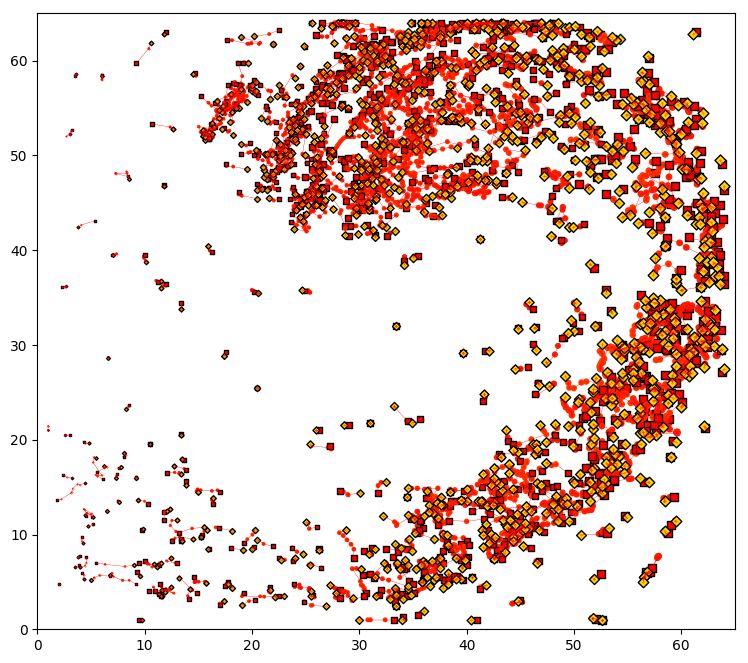

In [78]:
#PyPlot.ion()
figure(figsize=(9,8))
#axis("equal")
xlim(0.0,65.0)
ylim(0.0,65.0)
tolerancia=0
minlong=0
maxlong=20000
#colores=Union{}

for p in values(CatenarioPositivo)
    gordura=abs(p[:3])
    longus,gordus=size(p)
    if (mean(gordura)>tolerancia) && (longus>minlong) && longus < maxlong
        #Si son chiquitos no nos interesan.
        xxpos=p[:,1]
        yypos=p[:,2]    
        tiempos=p[:,4]/7022    
        plot(xxpos, yypos, marker="o", markersize=0.25, color="r", lw=0.25, zorder=15)
        colores=scatter(xxpos,yypos, s=gordura*0.4, edgecolors="none", 
        c=tiempos, cmap="autumn", vmin=0.0, vmax=0.72 )
        principios=scatter(xxpos[1],yypos[1], s=gordura*0.5,
        edgecolors="black", 
        color="r", marker="s", label="Inicio" ,
        zorder=1)
        finales=scatter(xxpos[end],yypos[end], s=gordura*0.5, edgecolors="black", 
        color="gold", marker="D", label="Final", zorder=2 )
        # annotate(round(tiempos[1],4),  (xxpos[1], yypos[1]), fontsize=7, color="black")
        # annotate(round(tiempos[end],4), (xxpos[end], yypos[end]), fontsize=7, color="green")

    end
end

#savefig("ejemploaltaspositivas-01.svg",dpi=92)

In [31]:
JLD.save

save (generic function with 8 methods)

In [36]:
save(nombreout, "CatenarioPositivo", CatenarioPositivo, "CatenarioNegativo", CatenarioNegativo, "notatray", nota)